In [184]:
# Импортируем нужные нам библиотеки
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set()
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
import numpy as np
import matplotlib.dates as mdates
import seaborn as sns
import matplotlib
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(15, 10)})
sns.set(font_scale=2)
sns.set_style("whitegrid")
import math

In [206]:
## Напишем совственную метрику, которая будет считать среднее взвешенное между r2 и уровнем сервиса


@ np.vectorize
def service_rate(y, y_hat):
    """уровень сервиса - негладкая функция, которая определяет насколько прогнозного ресурса хватило бы 
        для удовлетворения спроса"""
    
    result = 1 if not y else y_hat/y
    
    return 1 if result > 1 else result


def r2_s_rate(y, y_hat):
    
    """балансируем прожорливый по отношению к ресурсам(велосипедам) уровень сервиса коэффициентом детерминации"""
    
    s_r = service_rate(y, y_hat).mean()
    r2 = r2_score(y, y_hat)
    
    return s_r*r2, s_r, r2

def search_param(actual:pd.Series) -> pd.DataFrame:
    
    """будем искать оптимальное количество дней для rolling().max() и shift """
    
    result = []    
    for i in range(1,30):        
        rolled = actual.rolling(i,center=False).max()
        
        for j in range(1,30):
            bias = j+i            
            prediction = rolled.shift(j) 
            
            metrics = r2_s_rate(actual.iloc[bias:-bias], 
                                prediction.iloc[bias:-bias])
            
            result.append([i, j, metrics[0], metrics[1], metrics[2]])
    
    result = pd.DataFrame(result, columns = ['rolling', 'shift', 'r2_s_rate', 'service_rate', 'r2'])
    
    return result

In [207]:
bike_sharing = pd.read_csv(r'C:\Users\a.fadin\Documents\data science\time_series\bike-sharing.csv')

bike_sharing_ts = bike_sharing[['dteday', 'cnt']]

bike_sharing_ts['dteday'] = pd.to_datetime(bike_sharing_ts['dteday'], errors = 'coerce')

bike_sharing_ts.set_index('dteday', drop=True, inplace=True)

bike_sharing_ts_daily = bike_sharing_ts.resample('d').sum()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [208]:
params_ = search_param(bike_sharing_ts_daily.cnt)

In [212]:
params_.sort_values(by='r2_s_rate', ascending = False).head(3)

,rolling,shift,r2_s_rate,service_rate,r2
29,2,1,0.646778,0.957825,0.675257
0,1,1,0.635905,0.915848,0.694335
58,3,1,0.602010,0.974084,0.618026


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


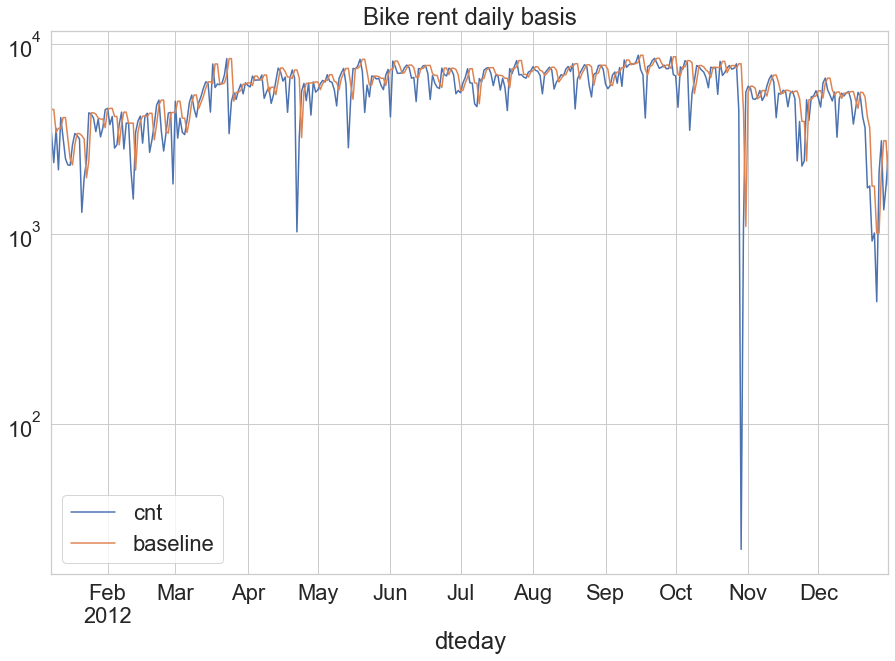

In [210]:
bike_sharing = pd.read_csv(r'C:\Users\a.fadin\Documents\data science\time_series\bike-sharing.csv')

bike_sharing_ts = bike_sharing[['dteday', 'cnt']]
bike_sharing_ts['dteday'] = pd.to_datetime(bike_sharing_ts['dteday'], errors = 'coerce')
bike_sharing_ts.set_index('dteday', drop=True, inplace=True)

bike_sharing_ts_daily = bike_sharing_ts.resample('d').sum()

bike_sharing_ts_daily['baseline'] = bike_sharing_ts_daily.rolling(2,center=False).max()

bike_sharing_ts_daily['baseline'] = bike_sharing_ts_daily['baseline'].shift(1)
bike_sharing_ts_daily.loc['01-08-2012':].plot(title = 'Bike rent daily basis', logy=True)